## Setup environment

In [33]:
# Mount GDrive
# from google.colab import drive
# drive.mount('/content/drive/')

# Move to the proper directory
% cd /content/drive/MyDrive/ENEL645/Project

# Check to see if present working directory is correct
! pwd

# unzip the data set
# ! unzip dataset.zip
# ! mv Dataset dataset

# Add utils path
# import sys
# MY_UTILS_PATH = ''
# if not MY_UTILS_PATH in sys.path:
#     sys.path.append(MY_UTILS_PATH)

/content/drive/MyDrive/ENEL645/Project
/content/drive/MyDrive/ENEL645/Project


## Import libraries

In [34]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import helpers


## Prepare and explore data

In [ ]:
# helpers.revise_fnames('dataset/train/image')
# helpers.revise_fnames('dataset/train/label')
# helpers.revise_fnames('dataset/test/label')
# helpers.revise_fnames('dataset/test/image')

In [85]:
INPUT_DIR = 'dataset/train/image/'
TARGET_DIR = 'dataset/train/label/'
TEST_INPUT_DIR = 'dataset/test/image/'
TEST_TARGET_DIR = 'dataset/test/label/'
IMG_SIZE = (480, 640)
N_CHANNELS = 4
BATCH_SIZE = 1
# SEED = 909
CLASSES = {
    0: 'Background',
    1: 'Field',
    2: 'Lines',
    3: 'Ball',
    4: 'Robots',
    5 : 'Goals',
}


input_paths = sorted(
    [
        os.path.join(INPUT_DIR, fname)
        for fname in os.listdir(INPUT_DIR)
        if fname.endswith('.png')
    ]
)
print(f'Found {len(input_paths)} images.')

target_paths = sorted(
    [
        os.path.join(TARGET_DIR, fname)
        for fname in os.listdir(TARGET_DIR)
        if fname.endswith('.png')
    ]
)
print(f'Found {len(target_paths)} masks.')

if (len(input_paths) != len(target_paths)):
    raise Exception('dataset errror')

test_input_paths = sorted(
    [
        os.path.join(TEST_INPUT_DIR, fname)
        for fname in os.listdir(TEST_INPUT_DIR)
        if fname.endswith('.jpg')
    ]
)
print(f'Found {len(test_input_paths)} test images.')

test_target_paths = sorted(
    [
        os.path.join(TEST_TARGET_DIR, fname)
        for fname in os.listdir(TEST_TARGET_DIR)
        if fname.endswith('.png')
    ]
)
print(f'Found {len(test_target_paths)} test masks.')

num_classes = len(CLASSES)
print('Number of classes:', num_classes)

print('Paths: ')
for input_path, target_path in zip(input_paths[:5], target_paths[:5]):
    print(input_path, '|', target_path)


# Shuffle the data
indexes = np.arange(len(input_paths), dtype=int)
np.random.shuffle(indexes)

input_paths = [input_paths[i] for i in indexes]
target_paths = [target_paths[i] for i in indexes]

print('Paths after shuffle: ')

for input_path, target_path in zip(input_paths[:5], target_paths[:5]):
    print(input_path, '|', target_path)

Found 2317 images.
Found 2317 masks.
Found 100 test images.
Found 100 test masks.
Number of classes: 6
Paths: 
dataset/train/image/0001.png | dataset/train/label/0001.png
dataset/train/image/0002.png | dataset/train/label/0002.png
dataset/train/image/0003.png | dataset/train/label/0003.png
dataset/train/image/0004.png | dataset/train/label/0004.png
dataset/train/image/0005.png | dataset/train/label/0005.png
Paths after shuffle: 
dataset/train/image/0354.png | dataset/train/label/0354.png
dataset/train/image/0255.png | dataset/train/label/0255.png
dataset/train/image/1271.png | dataset/train/label/1271.png
dataset/train/image/1739.png | dataset/train/label/1739.png
dataset/train/image/2047.png | dataset/train/label/2047.png


## Display the data

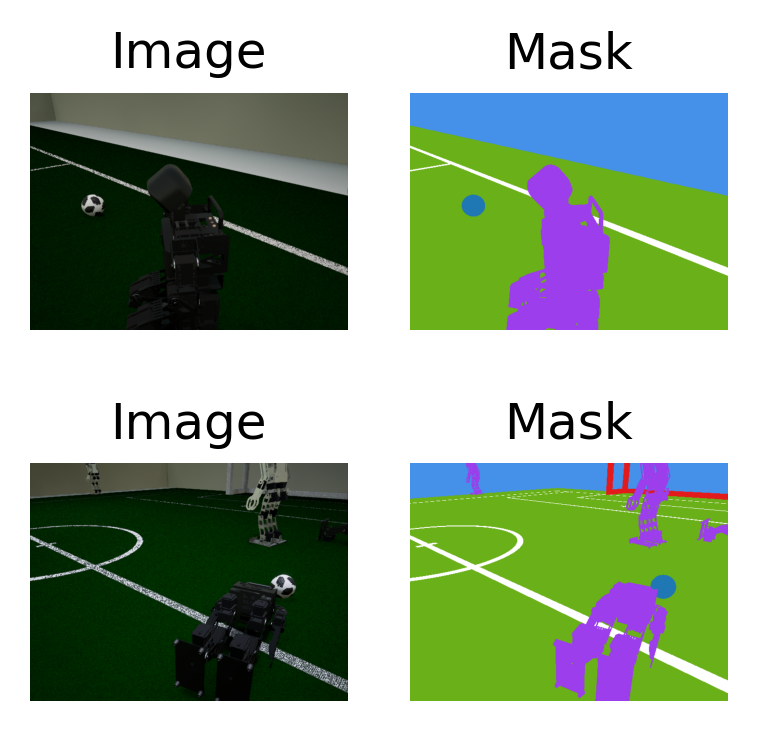

In [125]:
plt.figure(figsize=(3, 3), dpi=300)
for i in range(2):
    img = plt.imread(input_paths[i])
    plt.subplot(2, 2, i*2+1)
    plt.imshow(img/img.max())
    plt.axis('off')
    plt.title('Image')

    plt.subplot(2, 2, i*2+2)
    mask = tf.keras.preprocessing.image.load_img(target_paths[i], color_mode='rgb', target_size=IMG_SIZE)
    mask = tf.keras.preprocessing.image.img_to_array(mask)
    plt.imshow(mask/mask.max())
    plt.axis('off')
    plt.title('Mask')
plt.show()

## Create helper to iterate over the data

In [94]:
mapping = {
    (31, 120, 180): 0,
    (106, 176, 25): 1,
    (156, 62, 235): 2,
    (255, 255, 25): 3,
    (69, 144, 23): 4,
    (227, 26, 28): 5,
}

class DataSequence(tf.keras.utils.Sequence):
    '''Helper to iterate over the data as Numpy arrays.'''

    def __init__(self, in_paths, out_paths, batch_size=BATCH_SIZE, img_size=IMG_SIZE, n_channels=N_CHANNELS, n_classes=num_classes, is_test=False):
        self.input_paths = in_paths
        self.target_paths = out_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.is_test = is_test

    def __len__(self):
        return len(self.target_paths) // self.batch_size

    def __getitem__(self, idx):
        '''Returns tuple (input, target) correspond to batch #idx.'''
        i = idx * self.batch_size
        batch_input_paths = self.input_paths[i: i + self.batch_size]
        batch_target_paths = self.target_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size, ) + self.img_size + (self.n_channels, ), dtype='float32')
        for j, path in enumerate(batch_input_paths):
            img = tf.keras.preprocessing.image.load_img(path, color_mode='rgb' if self.is_test else 'rgba', target_size=self.img_size)
            if (self.is_test):
                pass
                # img = img.convert('RGBA')
            img = tf.keras.preprocessing.image.img_to_array(img)
            # img = plt.imread(path)
            if (img.max() > 1 and img.max() <= 255):
                img = img/255
            elif (img.max() > 255):
                img = img/1023
            x[j] = img
        y = np.zeros((self.batch_size, ) + self.img_size + (self.n_classes, ), dtype='uint8')
        for j, path in enumerate(batch_target_paths):
            mask = tf.keras.preprocessing.image.load_img(path, color_mode='rgb', target_size=self.img_size)
            mask = tf.keras.preprocessing.image.img_to_array(mask)
            result = np.ndarray(shape=mask.shape[:2], dtype=int)
            result[:,:] = -1
            for rgb, idx in mapping.items():
                result[(mask==rgb).all(2)] = idx

            # mask = plt.imread(path)
            result = tf.keras.utils.to_categorical(result, self.n_classes)
            y[j] = result
        return x, y


## Split data into train / validation / test

In [95]:
# Split our img paths into a training and a validation set
val_samples = int(0.15 * len(input_paths))
sim_test_samples = int(0.05 * len(input_paths))
train_samples = len(input_paths) - val_samples - sim_test_samples

train_input_paths = input_paths[:train_samples]
train_target_paths = target_paths[:train_samples]

val_input_paths = input_paths[train_samples:train_samples + val_samples]
val_target_paths = target_paths[train_samples:train_samples + val_samples]

sim_test_input_paths = input_paths[train_samples + val_samples: train_samples + val_samples + sim_test_samples]
sim_test_target_paths = target_paths[train_samples + val_samples:train_samples + val_samples + sim_test_samples]

# Instantiate data Sequences for each split
train_gen = DataSequence(train_input_paths, train_target_paths)
val_gen = DataSequence(val_input_paths, val_target_paths)
sim_test_gen = DataSequence(sim_test_input_paths, sim_test_target_paths)
test_gen = DataSequence(test_input_paths, test_target_paths, is_test=True)

## Define the model

In [96]:
def get_unet_mod(num_classes=num_classes, img_size=IMG_SIZE, learning_rate=1e-3, \
                learning_decay=1e-6, drop_out=0.1, nchannels=N_CHANNELS, kshape=(3, 3)):
    '''Get U-Net model with gaussian noise and dropout'''
    
    inputs = tf.keras.Input(shape=img_size + (nchannels, ))

    x = inputs
    # downstack
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(conv4)

    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)

    # upstack
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Concatenate()([conv4, x])
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Concatenate()([conv3, x])
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Concatenate()([conv2, x])
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Concatenate()([conv1, x])
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(num_classes, (1, 1), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs=x)

    opt = tf.keras.optimizers.Adam(lr= learning_rate, decay = learning_decay)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

tf.keras.backend.clear_session()

# Build model
model = get_unet_mod(num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 480, 640, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 640, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 240, 320, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Define callbacks

In [97]:
model_name = 'unet_seg.h5'
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True,\
                                             save_weights_only=True, mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%3 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

callbacks = [early_stop, monitor, lr_schedule]

## Train the model

In [98]:
# Train the model, doing validation at the end of each epoch.
epochs = 1
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

1855/1855 [==============================] - 234s 125ms/step - loss: 0.1925 - accuracy: 0.9457 - val_loss: 0.0288 - val_accuracy: 0.9902


## Extract metrics

In [101]:
model.load_weights(model_name)
# metrics = model.evaluate(test_gen)
# print('Categorical cross-entropy:', metrics[0])
# print('Accuracy:', metrics[1])

sim_metrics = model.evaluate(sim_test_gen)
print('Simulation:')
print('Categorical cross-entropy:', sim_metrics[0])
print('Accuracy:', sim_metrics[1])

115/115 [==============================] - 10s 82ms/step - loss: 0.0365 - accuracy: 0.9870
Simulation:
Categorical cross-entropy: 0.03649348393082619
Accuracy: 0.9869974851608276


## Visualize test results

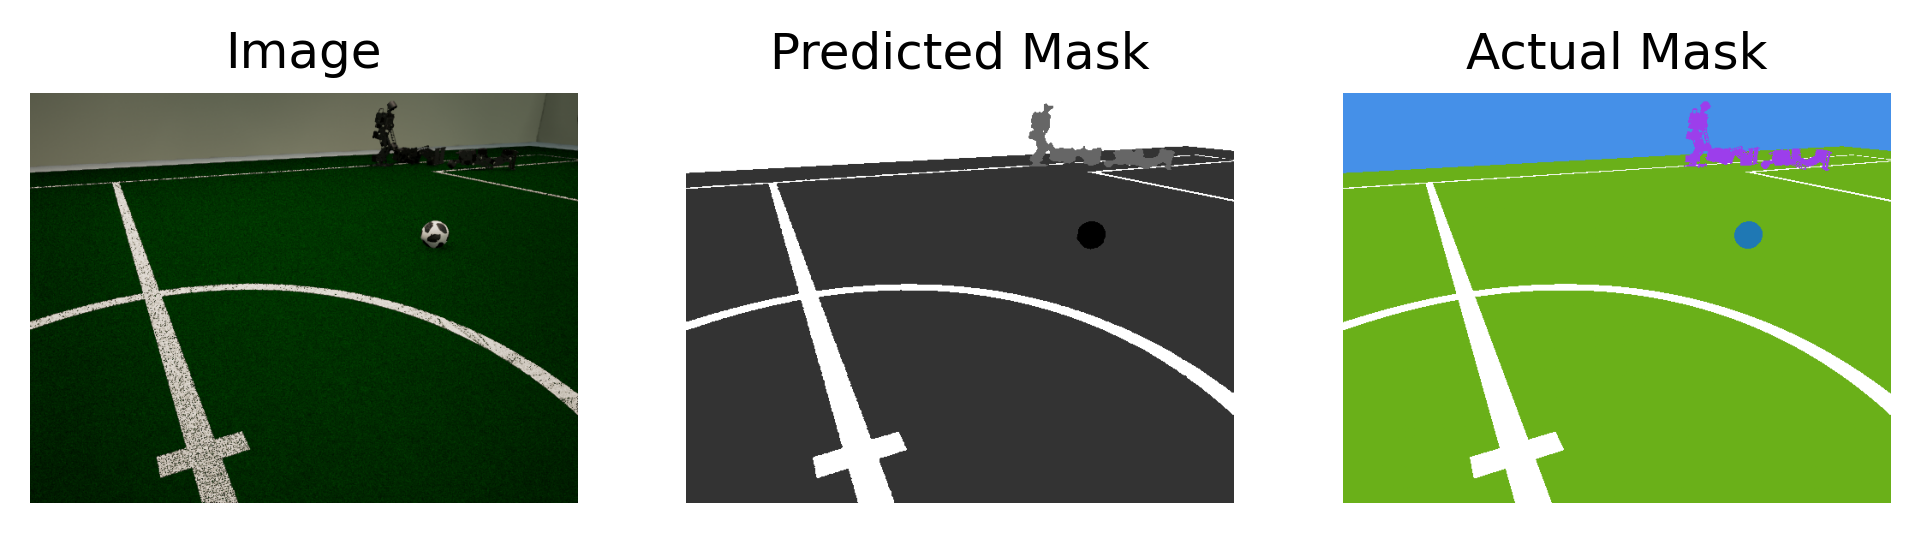

In [121]:
# test_preds = model.predict(test_gen)

# plt.figure(figsize=(12,18), dpi=300)
# for i in range(1):
#     img = plt.imread(test_input_paths[i])
#     plt.subplot(2, 3, i*3+1)
#     plt.imshow(img/img.max())
#     plt.axis('off')
#     plt.title('Image')
#     plt.subplot(2, 3, i*3+2)
#     predicted_mask = np.argmax(test_preds[i], axis=-1)
#     # predicted_mask = np.expand_dims(predicted_mask, axis=-1)
#     plt.imshow(predicted_mask/predicted_mask.max(), cmap='gray')
#     plt.axis('off')
#     plt.title('Predicted Mask')
#     plt.subplot(2, 3, i*3+3)
#     actual_mask = plt.imread(test_target_paths[i])
#     plt.imshow(actual_mask/actual_mask.max())
#     plt.axis('off')
#     plt.title('Actual Mask')
# plt.show()

# x = np.zeros((BATCH_SIZE, ) + IMG_SIZE + (N_CHANNELS, ), dtype='float32')
# for j in range(BATCH_SIZE):
#     img = tf.keras.preprocessing.image.load_img(sim_test_input_paths[j], color_mode='rgba', target_size=IMG_SIZE)
#     img = tf.keras.preprocessing.image.img_to_array(img)
#     # img = plt.imread(path)
#     if (img.max() > 1 and img.max() <= 255):
#         img = img/255
#     elif (img.max() > 255):
#         img = img/1023
#     x[j] = img

# test_preds = model.predict(sim_test_gen)

plt.figure(figsize=(8, 5), dpi=300)
for i in range(1):
    img = plt.imread(sim_test_input_paths[i+2])
    plt.subplot(1, 3, i*3+1)
    plt.imshow(img/img.max())
    plt.axis('off')
    plt.title('Image')
    plt.subplot(1, 3, i*3+2)
    predicted_mask = np.argmax(test_preds[i+2], axis=-1)

    plt.imshow(predicted_mask/predicted_mask.max(), cmap='gray')
    plt.axis('off')
    plt.title('Predicted Mask')
    plt.subplot(1, 3, i*3+3)
    actual_mask = tf.keras.preprocessing.image.load_img(sim_test_target_paths[i+2], color_mode='rgb', target_size=IMG_SIZE)
    actual_mask = tf.keras.preprocessing.image.img_to_array(actual_mask)
    plt.imshow(actual_mask/actual_mask.max())
    plt.axis('off')
    plt.title('Actual Mask')
plt.show()